# IMPORT PACKAGES

In [129]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import vector_tools as vt

# CREATE DATAFRAME
- Use data from the raw ".dat" file and the ".sen" file to compile a comprehensive dataframe

In [ ]:
# "vector_to_df" is a function from the vector_tools package that takes the raw .dat and .sen files and compiles them into a single user-friendly dataframe
adv1 = vt.vector_to_df('ADV/DEPL_204a.dat', 'ADV/DEPL_204a.sen', 32)
adv2 = vt.vector_to_df('ADV/DEP205.dat', 'ADV/DEP205.sen', 32)

In [128]:
# Export raw df's to csv's for later use
adv1.to_csv('ADV/adv1_raw.csv')
adv2.to_csv('ADV/adv2_raw.csv')

In [ ]:
adv1 = pd.read_csv('ADV/adv1_raw.csv', index_col= False) # Reimports the .csv file
adv1.drop(adv1.columns[0], axis=1, inplace=True) # Pandas adds a new 'unnamed' columned for whatever reason, this drops that column

adv2 = pd.read_csv('ADV/adv2_raw.csv', index_col= False)
adv2.drop(adv2.columns[0], axis=1, inplace=True)

# DATA QUALITY CONTROL

#### Quality control parameters
- Data still contains deployment and retrieval values, as well as some 'bad' data points that must be filtered
    - Beam correlation
        - < 70% = 20 (Fail)
        - 70-80% = 1 (Acceptable but suspicious)
        - Greater than 80% = 0 (Pass)
    - Roll and Pitch
        - Greater than 2 degrees = 4 (Fail)
        - < 2 degrees = 0 (Pass)
    - Pressure
        - Min depth during low tide is ~8m, anything lower likely during deployment/recovery of instrument
        - < 8 = 4 (Fail)
        - Greater than 8 = 0 (Pass)
    - Phase wrapping and acceleration
        - Nominal velocity range is ~ +/- 2.1m/s
        - Any change in velocity > 1m/s is highly unlikely between 1/32 second intervals
        - Greater than 2m/s = 4 (Fail)
        - Between 1-2m/s = 2 (Suspect)
        - < 1m/s = 0 (Pass)

In [130]:
# This function adds data quality flags to the previously generated dataframe
adv1_flagged = vt.adv_df_flag('ADV/adv1_raw.csv', 2, 8) # 2 is the tilt threshold (in degrees), 8 is the minimum pressure threshold (in dbar)
adv2_flagged = vt.adv_df_flag('ADV/adv2_raw.csv', 2, 8)

In [131]:
adv1_flagged

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),...,Roll,Temperature,Flag,Flag_pw,Nor_diff,Nor_absdiff,Eas_diff,Eas_absdiff,Up_diff,Up_absdiff
0,2022-08-02 09:40:02.000000,1,1,-0.128,-0.219,-0.110,42,43,43,-1.7,...,-25.7,21.71,72,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-02 09:40:02.031250,1,2,0.272,-0.216,-0.220,42,43,42,-1.7,...,-25.7,21.71,72,0,0.003,0.003,0.400,0.400,-0.110,0.110
2,2022-08-02 09:40:02.062500,1,3,0.484,1.625,0.442,41,41,43,-2.1,...,-25.7,21.71,72,1,1.841,1.841,0.212,0.212,0.662,0.662
3,2022-08-02 09:40:02.093750,1,4,1.285,0.047,-0.538,44,41,43,-0.9,...,-25.7,21.71,72,1,-1.578,1.578,0.801,0.801,-0.980,0.980
4,2022-08-02 09:40:02.125000,1,5,1.711,0.779,-0.097,42,45,43,-1.7,...,-25.7,21.71,72,0,0.732,0.732,0.426,0.426,0.441,0.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639995,2022-08-11 17:56:17.843750,225,38396,-0.871,-1.739,0.407,40,40,40,-0.4,...,-22.3,24.02,72,5,-3.447,3.447,-1.723,1.723,0.941,0.941
8639996,2022-08-11 17:56:17.875000,225,38397,-0.311,0.232,-0.375,42,41,42,0.4,...,-22.3,24.02,72,1,1.971,1.971,0.560,0.560,-0.782,0.782
8639997,2022-08-11 17:56:17.906250,225,38398,-0.679,1.562,-1.043,39,41,43,-0.9,...,-22.3,24.02,72,1,1.330,1.330,-0.368,0.368,-0.668,0.668
8639998,2022-08-11 17:56:17.937500,225,38399,-0.345,-0.948,0.516,40,41,39,-0.4,...,-22.3,24.02,72,5,-2.510,2.510,0.334,0.334,1.559,1.559


In [132]:
adv2_flagged

,Datetime,Burst_counter,Ensemble_counter,Velocity_East(m/s),Velocity_North(m/s),Velocity_Up(m/s),Amplitude_B1(counts),Amplitude_B2(counts),Amplitude_B3(counts),SNR_B1(dB),...,Roll,Temperature,Flag,Flag_pw,Nor_diff,Nor_absdiff,Eas_diff,Eas_absdiff,Up_diff,Up_absdiff
0,2022-08-15 06:40:02.000000,1,1,0.957,0.370,0.057,42,43,42,0.4,...,26.2,20.70,72,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-15 06:40:02.031250,1,2,-0.231,-0.597,-0.259,41,40,41,0.0,...,26.2,20.70,72,1,-0.967,0.967,-1.188,1.188,-0.316,0.316
2,2022-08-15 06:40:02.062500,1,3,-0.842,0.547,0.416,43,40,42,0.9,...,26.2,20.70,72,1,1.144,1.144,-0.611,0.611,0.675,0.675
3,2022-08-15 06:40:02.093750,1,4,-0.082,0.171,-0.032,43,40,41,0.9,...,26.2,20.70,72,0,-0.376,0.376,0.760,0.760,-0.448,0.448
4,2022-08-15 06:40:02.125000,1,5,-1.253,-0.233,0.554,41,42,41,0.0,...,26.2,20.70,72,1,-0.404,0.404,-1.171,1.171,0.586,0.586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14204731,2022-08-30 15:52:10.843750,370,35132,-0.599,-3.159,0.018,39,40,42,-0.9,...,20.5,28.03,72,9,-3.068,3.068,-2.134,2.134,1.068,1.068
14204732,2022-08-30 15:52:10.875000,370,35133,1.496,0.386,-0.630,41,41,41,0.0,...,20.5,28.03,72,8,3.545,3.545,2.095,2.095,-0.648,0.648
14204733,2022-08-30 15:52:10.906250,370,35134,0.321,1.591,-0.085,41,41,40,0.0,...,20.5,28.03,72,2,1.205,1.205,-1.175,1.175,0.545,0.545
14204734,2022-08-30 15:52:10.937500,370,35135,1.757,-1.214,-0.858,40,41,42,-0.4,...,20.5,28.03,72,5,-2.805,2.805,1.436,1.436,-0.773,0.773


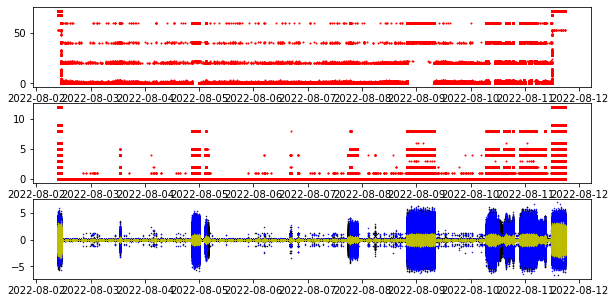

In [133]:
plt.figure(figsize = (10,5))

plt.subplot(311)
plt.plot(adv1_flagged.Datetime, adv1_flagged.Flag, '.r', ms = 2)

plt.subplot(312)
plt.plot(adv1_flagged.Datetime, adv1_flagged.Flag_pw, '.r', ms = 2)

plt.subplot(313)
plt.plot(adv1_flagged.Datetime, adv1_flagged.Nor_diff, '.k', ms = 1)
plt.plot(adv1_flagged.Datetime, adv1_flagged.Eas_diff, '.b', ms = 1)
plt.plot(adv1_flagged.Datetime, adv1_flagged.Up_diff, '.y', ms = 1)

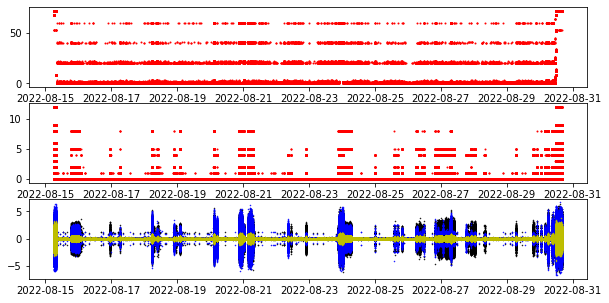

In [134]:
plt.figure(figsize = (10,5))

plt.subplot(311)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Flag, '.r', ms = 2)

plt.subplot(312)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Flag_pw, '.r', ms = 2)

plt.subplot(313)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Nor_diff, '.k', ms = 1)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Eas_diff, '.b', ms = 1)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Up_diff, '.y', ms = 1)

In [86]:
# Before moving on to phase wrapping correction, create a subset of data which excludes data with flag >10
ADV1_sub = ADV1[(ADV1['Flag'] < 4) & (ADV1['Flag_pw'] < 4)]

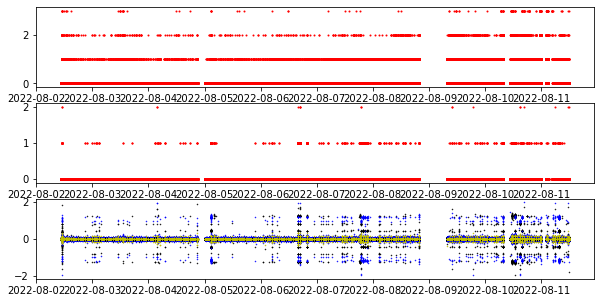

In [88]:
plt.figure(figsize = (10,5))

plt.subplot(311)
plt.plot(ADV1_sub.Datetime, ADV1_sub.Flag, '.r', ms = 2)

plt.subplot(312)
plt.plot(ADV1_sub.Datetime, ADV1_sub.Flag_pw, '.r', ms = 2)

plt.subplot(313)
plt.plot(ADV1_sub.Datetime, ADV1_sub.Nor_diff, '.k', ms = 1)
plt.plot(ADV1_sub.Datetime, ADV1_sub.Eas_diff, '.b', ms = 1)
plt.plot(ADV1_sub.Datetime, ADV1_sub.Up_diff, '.y', ms = 1)

In [89]:
len(ADV1)

8640000

In [90]:
len(ADV1_sub)

7174882

## If phase wrapping is present
- Convert velocities from ENU to beam by using the transformation matrix in .hdr files
    - The following code is based on a MatLab script available on NORTEK's FAQ forums:
        https://support.nortekgroup.com/hc/en-us/articles/360029820971-How-is-a-coordinate-transformation-done-
        - Most relevant information is available in the .hdr file
        - You will need the transformation matrix, as well as heading, pitch, and roll data for each sample to make the conversions
    - Once velocities have been converted, calculate the ambiguous velocity V_amb
    - Run a patch over the entire BEAM velocity dataset
        - If phase wrap is negative: newvel = oldvel + 2*V_amb
        - If phase wrap is positive: newvel = oldvel - 2*V_amb
    -Convert patched velocities back to ENU for more user-friendly data

In [52]:
# Transformation matrix located in .hdr file as 'Transformation matrix'

T = np.array([[2.7249, -1.3770, -1.3503], #Convert matrix to multidimensional numpy array
   [-0.0161, 2.3442, -2.3308],
   [0.3472, 0.3455, 0.3389]])

# Heading, pitch and roll are the angles output in the data in degrees
# Convert to radians
hh = np.pi*(adv1_flagged['Heading']-90)/180 #Creates list of hh, pp, and rr for all datapoints
pp = np.pi * (adv1_flagged['Pitch']/180)
rr = np.pi * (adv1_flagged['Roll']/180)

# Generate empty arrays to be populated by resulting beam velocities
beam1 = np.empty(len(adv1_flagged)) # Already created to be the length of the dataset to save processing time
beam2 = np.empty(len(adv1_flagged))
beam3 = np.empty(len(adv1_flagged))

In [ ]:
# Calculate heading matrix and tilt matrix for each data point and convert ENU velocities to beam velocities

# for loop iterates for each data point
for i in range(0,len(adv1_flagged)):
    if i % 1000000 == 0: # Progress check every 1000000 rows
                print('Currently on row:', i)
            
    H = np.array([[np.cos(hh[i]), np.sin(hh[i]), 0], # Makes the heading matrix for row i
                  [-np.sin(hh[i]), np.cos(hh[i]), 0], 
                  [0, 0, 1]])
    
    P = np.array([[np.cos(pp[i]), -np.sin(pp[i])*np.sin(rr[i]), -np.cos(rr[i])*np.sin(pp[i])], # Makes the tilt matrix for row i
                  [0, np.cos(rr[i]), -np.sin(rr[i])], 
                  [np.sin(pp[i]), np.sin(rr[i])*np.cos(pp[i]), np.cos(pp[i])*np.cos(rr[i])]])
    
    R = H*P*T #Product of transformation, heading, and tilt matrix creates conversion matrix R

    # Retrieves ENU velocities from row i to be converted by R[i]
    enu = np.array([adv1_flagged['Velocity_East(m/s)'][i], adv1_flagged['Velocity_North(m/s)'][i], adv1_flagged['Velocity_Up(m/s)'][i]])
    
    beam1[i] = np.dot(np.linalg.inv(R),enu)[0]
    beam2[i] = np.dot(np.linalg.inv(R),enu)[1]
    beam3[i] = np.dot(np.linalg.inv(R),enu)[2]

### Calculate v_amb
 - v_amb = VR * 2
 - VR = c/(4 * f * tlag(s))
 - c = 1530 (speed of sound measured by instrument)
 - f = instrument frequency (6000kHz)
 - tlag (for vector) = 50/480000 (50 is from system 38 in .hdr file, which indicates nominal velocity of 1m/s)

In [ ]:
c = 1530
f = 6000000
tlag = 50/480000
VR = c / (4 * f * tlag)
v_amb = VR *2
v_amb

### Convert data to xarray

In [2]:
#ADV1 = pd.read_csv('ADV/ADV1_qc.csv')
#ADV2 = pd.read_csv('ADV/ADV2_qc.csv')

In [167]:
adv1_ds = adv_df_to_ds(adv1_flagged)
adv2_ds = adv_df_to_ds(adv2_flagged)

In [168]:
adv1_ds

<xarray.Dataset>
Dimensions:         (burst: 8640000, time: 8640000)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-02T09:40:02 ... 2022-08-11T...
  * burst           (burst) int64 1 1 1 1 1 1 1 ... 225 225 225 225 225 225 225
Data variables:
    Burst_number    (time) int64 1 1 1 1 1 1 1 1 ... 225 225 225 225 225 225 225
    East            (time) float64 -0.128 0.272 0.484 ... -0.679 -0.345 0.964
    North           (time) float64 -0.219 -0.216 1.625 ... 1.562 -0.948 0.456
    Vertical        (time) float64 -0.11 -0.22 0.442 ... -1.043 0.516 -0.135
    Magnitude       (time) float64 0.2537 0.3473 1.696 ... 1.703 1.009 1.066
    Direction       (time) float64 221.8 220.1 222.1 220.8 ... 13.84 16.22 15.44
    Heading         (time) float64 220.8 220.8 220.8 220.8 ... 15.0 15.0 15.0
    Pitch           (time) float64 -5.9 -5.9 -5.9 -5.9 ... -18.8 -18.8 -18.8
    Roll            (time) float64 -25.7 -25.7 -25.7 -25.7 ... -22.3 -22.3 -22.3
    Temperature     (time) float64 21.71 21.71 21.71 21.71 ... 24.02 24.02 24.02
    Pressure        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.024 0.0 0.0 0.0 0.0
    Correlation_B1  (time) int64 20 21 15 24 12 15 39 15 ... 18 6 17 2 43 18 18
    Correlation_B2  (time) int64 25 16 31 23 22 23 30 1 ... 21 35 25 13 27 29 29
    Correlation_B3  (time) int64 21 30 32 7 24 16 21 32 ... 17 8 16 37 7 13 14
    Flag            (time) int64 72 72 72 72 72 72 72 ... 72 72 72 72 72 72 72
    Flag_pw         (time) int64 0 0 1 1 0 0 2 3 5 3 1 ... 5 1 3 4 5 1 5 1 1 5 2
Attributes:
    description:  ADV data

In [169]:
adv2_ds

<xarray.Dataset>
Dimensions:         (burst: 14204736, time: 14204736)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-15T06:40:02 ... 2022-08-30T...
  * burst           (burst) int64 1 1 1 1 1 1 1 ... 370 370 370 370 370 370 370
Data variables:
    Burst_number    (time) int64 1 1 1 1 1 1 1 1 ... 370 370 370 370 370 370 370
    East            (time) float64 0.957 -0.231 -0.842 ... 0.321 1.757 -0.107
    North           (time) float64 0.37 -0.597 0.547 ... 1.591 -1.214 -1.487
    Vertical        (time) float64 0.057 -0.259 0.416 ... -0.085 -0.858 -0.104
    Magnitude       (time) float64 1.026 0.6401 1.004 ... 1.623 2.136 1.491
    Direction       (time) float64 22.27 23.1 21.32 20.78 ... 330.7 328.7 330.8
    Heading         (time) float64 21.9 21.9 21.9 21.9 ... 329.3 329.3 329.3
    Pitch           (time) float64 3.3 3.3 3.3 3.3 ... -18.1 -18.1 -18.1 -18.1
    Roll            (time) float64 26.2 26.2 26.2 26.2 ... 20.5 20.5 20.5 20.5
    Temperature     (time) float64 20.7 20.7 20.7 20.7 ... 28.03 28.03 28.03
    Pressure        (time) float64 0.0 0.0 0.0 0.0 ... 0.034 0.019 0.029 0.024
    Correlation_B1  (time) int64 23 5 16 24 34 27 31 4 ... 29 25 35 43 6 20 44 4
    Correlation_B2  (time) int64 4 22 21 31 34 20 31 18 ... 29 6 18 29 9 32 41
    Correlation_B3  (time) int64 6 52 27 29 34 17 23 17 ... 12 14 7 32 6 30 21
    Flag            (time) int64 72 72 72 72 72 72 72 ... 72 72 72 72 72 72 72
    Flag_pw         (time) int64 0 1 1 0 1 2 1 2 2 4 8 ... 2 0 5 5 2 1 9 8 2 5 1
Attributes:
    description:  ADV data

In [170]:
#adv1_ds.to_netcdf('ADV/adv1.nc')
#adv2_ds.to_netcdf('ADV/adv2.nc')

# ANALYSIS

### Wave Excursion

In [30]:
# Calculate the magnitude of ADV velocity
ADV1_hvel = ((ADV1_qc['Velocity_East(m/s)'])**2) + ((ADV1_qc['Velocity_North(m/s)'])**2)
ADV2_hvel = ((ADV2_qc['Velocity_East(m/s)'])**2) + ((ADV2_qc['Velocity_North(m/s)'])**2)

In [38]:
np.mean(ADV1_hvel)*100

0.17559164691058443

In [37]:
np.std(ADV1_hvel)*100

1.8011597591776285

In [39]:
np.mean(ADV2_hvel)*100

0.20338992054437732

In [40]:
np.std(ADV2_hvel)*100

2.4592097776092916